<h1>RL-based trading algos</h1>

In [6]:
%pip install gym
%pip install numpy
%pip install torch

import gym
import numpy as np
from gym import spaces
import torch
import random
from collections import deque
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import uts

utils = uts.Utilities(is_test=uts.IS_TEST, test_num=uts.TEST_NUM)
etf_dfs = utils.get_dataframes('data/ETFs')
stock_dfs = utils.get_dataframes('data/Stocks') 


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/var/folders/39/b1_5gh0n1c19tnncpdphyxjm0000gn/T/ipykernel_65768/3508327744.py:87: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  s = torch.FloatTensor(s)


Episode 1, Reward: 5678532.20, Epsilon: 0.0100
Final Portfolio Value: 11719.15
Episode 2, Reward: -1302607.85, Epsilon: 0.0100
Final Portfolio Value: 9418.39
Episode 3, Reward: 62292612.67, Epsilon: 0.0100
Final Portfolio Value: 56336.23
Episode 4, Reward: 1362917.48, Epsilon: 0.0100
Final Portfolio Value: 10103.42
Episode 5, Reward: -3471068.75, Epsilon: 0.0100
Final Portfolio Value: 9185.92
Episode 6, Reward: 44000573.94, Epsilon: 0.0100
Final Portfolio Value: 32142.18
Episode 7, Reward: 10357238.00, Epsilon: 0.0100
Final Portfolio Value: 15361.23
Episode 8, Reward: -9880027.84, Epsilon: 0.0100
Final Portfolio Value: 6918.46
Episode 9, Reward: 73044424.29, Epsilon: 0.0100
Final Portfolio Value: 69586.84
Episode 10, Reward: 167359.03, Epsilon: 0.0100
Final Portfolio Value: 10703.04
Episode 11, Reward: -7650356.56, Epsilon: 0.0100
Final Portfolio Value: 10357.94
Episode 12, Reward: 23842911.95, Epsilon: 0.0100
Final Portfolio Value: 26179.02
Episode 13, Reward: 35636728.16, Epsilon: 0.

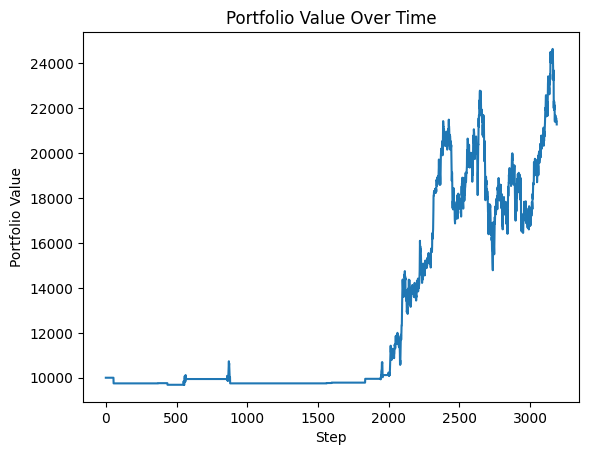

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class TradingEnv(gym.Env):
    def __init__(self, prices, window_size=10, initial_cash=10000):
        super().__init__()
        self.prices = prices
        self.window_size = window_size
        self.initial_cash = initial_cash
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(window_size,), dtype=np.float32)
        self.reset()

    def reset(self):
        self.cash = self.initial_cash
        self.shares = 0
        self.current_step = self.window_size
        self.done = False
        self.initial_cash_val = self.initial_cash
        return self._get_state()

    def _get_state(self):
        return self.prices[self.current_step - self.window_size:self.current_step]

    def step(self, action):
        price = self.prices[self.current_step]
        reward = 0

        if action == 1:
            shares_to_buy = int(self.cash / price)
            self.cash -= shares_to_buy * price
            self.shares += shares_to_buy

        elif action == 2 and self.shares > 0:
            self.cash += self.shares * price
            self.shares = 0

        self.current_step += 1
        if self.current_step >= len(self.prices):
            self.done = True

        total_value = self.cash + self.shares * price
        reward = total_value - self.initial_cash_val
        return self._get_state(), reward, self.done, {}

    def get_value(self):
        return self.cash + self.shares * self.prices[self.current_step-1]

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.target_model.load_state_dict(self.model.state_dict())
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.batch_size = 32

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.choice([0, 1, 2])  # Hold, Buy, Sell
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def remember(self, s, a, r, s2, done):
        self.memory.append((s, a, r, s2, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        s, a, r, s2, d = zip(*batch)
        s = torch.FloatTensor(s)
        a = torch.LongTensor(a).unsqueeze(1)
        r = torch.FloatTensor(r).unsqueeze(1)
        s2 = torch.FloatTensor(s2)
        d = torch.FloatTensor(d).unsqueeze(1)

        q = self.model(s).gather(1, a)
        q_next = self.target_model(s2).max(1)[0].unsqueeze(1)
        q_target = r + self.gamma * q_next * (1 - d)

        loss = nn.MSELoss()(q, q_target.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())

prices = stock_dfs[0]['Close'].values
env = TradingEnv(prices)
agent = DQNAgent(state_size=env.window_size, action_size=3)

EPISODES = 50
for ep in range(EPISODES):
    state = env.reset()
    total_reward = 0

    while True:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.replay()
        state = next_state
        total_reward += reward

        if done:
            break

    agent.update_target()
    print(f"Episode {ep + 1}, Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.4f}")

    final_value = env.get_value()
    print(f"Final Portfolio Value: {final_value:.2f}")

portfolio_values = []

state = env.reset()
while True:
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    portfolio_values.append(env.get_value())

    state = next_state
    if done:
        break

plt.plot(portfolio_values)
plt.title("Portfolio Value Over Time")
plt.xlabel("Step")
plt.ylabel("Portfolio Value")
plt.show()
